In [59]:
import numpy as np
import os
import random
import torch
from configs.configs import Configs
from models.predictor_model import EssayScorer
from transformers import AutoConfig
from utils.create_embedding_feautres import create_embedding_features
from utils.dvrl_utils import remove_top_p_sample, fit_func, pred_func, calc_qwk, random_remove_sample
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import japanize_matplotlib

load data from data/train_dev_test_split/8/fold-0/...
Loading embedding from cache...
load data from data/train_dev_test_split/1/fold-0/...
Loading embedding from cache...
X_train:  (1506, 1024)
Y_train:  (1506,)
Y_train max:  1.0
Y_train min:  0.0
X_dev:  (144, 1024)
Y_dev:  (144,)
Y_dev max:  0.8333333333333334
Y_dev min:  0.16666666666666666
X_test:  (144, 1024)
Y_test:  (144,)
Y_test max:  0.9166666666666666
Y_test min:  0.3333333333333333
Creating predictor model...
QWK: 0.6660
Creating predictor model...
QWK: 0.5904
Creating predictor model...
QWK: 0.6473
Creating predictor model...
QWK: 0.6304
Creating predictor model...
QWK: 0.5858
Creating predictor model...
QWK: 0.6322
Creating predictor model...
QWK: 0.6178
Creating predictor model...
QWK: 0.5911
Creating predictor model...
QWK: 0.6038
Creating predictor model...
QWK: 0.6149
Creating predictor model...
QWK: 0.5949
Creating predictor model...
QWK: 0.6128
Creating predictor model...
QWK: 0.5626
Creating predictor model...
QWK:

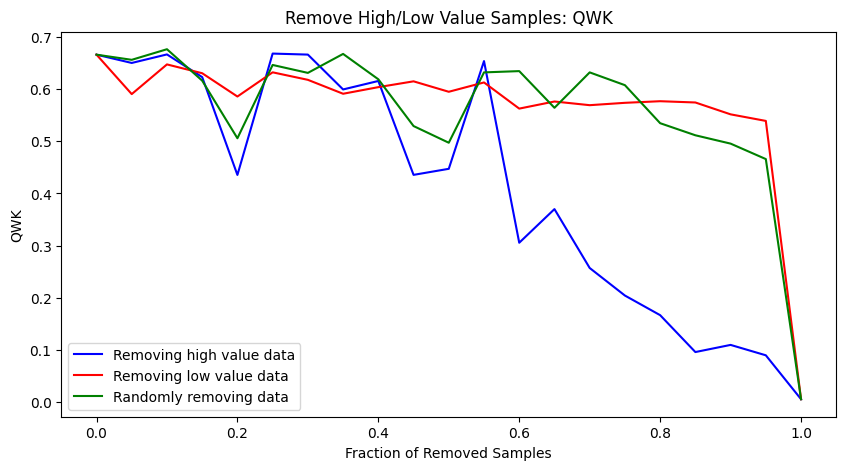

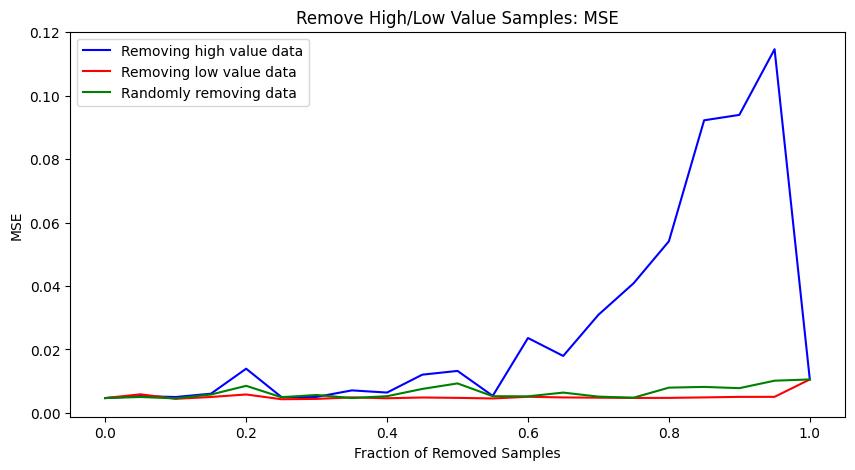

In [8]:
test_prompt_id = 8
output_path = f'outputs/DVRL_DomainAdaptation{test_prompt_id}/'

seed = 12
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
configs = Configs()
attribute_name = 'score'

# Load data
if test_prompt_id == 8:
    noise_prompt = 1
else:
    noise_prompt = test_prompt_id + 1
data_path1 = configs.DATA_PATH2 + str(test_prompt_id) + '/fold-0/'
data_path2 = configs.DATA_PATH2 + str(noise_prompt) + '/fold-0/'
model_name = 'microsoft/deberta-v3-large'

train_features1, dev_features1, test_features1, y_train1, y_dev1, y_test1 = create_embedding_features(data_path1, test_prompt_id, attribute_name, model_name, device)
train_features2, dev_features2, test_features2, y_train2, y_dev2, y_test2 = create_embedding_features(data_path2, noise_prompt, attribute_name, model_name, device)

# Concatenate data of prompt 1 and prompt 2
train_features = np.concatenate([train_features1, train_features2], axis=0)
y_train = np.concatenate([y_train1, y_train2], axis=0)

# print info
print('================================')
print('X_train: ', train_features.shape)
print('Y_train: ', y_train.shape)
print('Y_train max: ', np.max(y_train))
print('Y_train min: ', np.min(y_train))

print('================================')
print('X_dev: ', dev_features1.shape)
print('Y_dev: ', y_dev1.shape)
print('Y_dev max: ', np.max(y_dev1))
print('Y_dev min: ', np.min(y_dev1))

print('================================')
print('X_test: ', test_features1.shape)
print('Y_test: ', y_test1.shape)
print('Y_test max: ', np.max(y_test1))
print('Y_test min: ', np.min(y_test1))
print('================================')

# Remove high and low value samples
low_qwks = []
low_mse = []
for p in np.arange(0.0, 1.01, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = remove_top_p_sample(np.load(output_path + 'estimated_data_value.npy'), top_p=p, ascending=True)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, test_features1, batch_size=256, device=device)
    qwk = calc_qwk(y_test1, y_pred, test_prompt_id, 'score')
    mse = mean_squared_error(y_test1, y_pred)
    print(f'QWK: {qwk:.4f}')
    low_qwks.append(qwk)
    low_mse.append(mse)

np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

high_qwks = []
high_mse = []
for p in np.arange(0.0, 1.01, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = remove_top_p_sample(np.load(output_path + 'estimated_data_value.npy'), top_p=p, ascending=False)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, test_features1, batch_size=256, device=device)
    qwk = calc_qwk(y_test1, y_pred, test_prompt_id, 'score')
    mse = mean_squared_error(y_test1, y_pred)
    print(f'QWK: {qwk:.4f}')
    high_qwks.append(qwk)
    high_mse.append(mse)


np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

random_qwks = []
random_mse = []
for p in np.arange(0.0, 1.01, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = random_remove_sample(np.load(output_path + 'estimated_data_value.npy'), remove_p=p)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, test_features1, batch_size=256, device=device)
    qwk = calc_qwk(y_test1, y_pred, test_prompt_id, 'score')
    mse = mean_squared_error(y_test1, y_pred)
    print(f'QWK: {qwk:.4f}')
    random_qwks.append(qwk)
    random_mse.append(mse)

# plot
p = np.arange(0.0, 1.01, 0.05)
plt.figure(figsize=(10, 5))
plt.plot(p, high_qwks, label='Removing high value data', color='blue')
plt.plot(p, low_qwks, label='Removing low value data', color='red')
plt.plot(p, random_qwks, label='Randomly removing data', color='green')
plt.title('Remove High/Low Value Samples: QWK')
plt.xlabel('Fraction of Removed Samples')
plt.ylabel('QWK')
plt.legend()
plt.savefig(output_path + 'remove_high_low_samples_qwk.png')

plt.figure(figsize=(10, 5))
plt.plot(p, high_mse, label='Removing high value data', color='blue')
plt.plot(p, low_mse, label='Removing low value data', color='red')
plt.plot(p, random_mse, label='Randomly removing data', color='green')
plt.title('Remove High/Low Value Samples: MSE')
plt.xlabel('Fraction of Removed Samples')
plt.ylabel('MSE')
plt.legend()
plt.savefig(output_path + 'remove_high_low_samples_mse.png')

In [52]:
data_values = np.load(output_path + 'estimated_data_value.npy')

In [53]:
test_prompt_size = len(y_train1)
noise_prompt_size = len(y_train2)
prompts = []
for i in range(test_prompt_size):
    prompts.append(test_prompt_id)
for i in range(noise_prompt_size):
    prompts.append(noise_prompt)
prompts = np.array(prompts)

In [54]:
prompts_sorted_by_value = prompts[data_values.flatten().argsort()]

In [60]:
CF = []
for percent in np.arange(0, 1.01, 0.1):
    CF.append((prompts_sorted_by_value[:int(len(prompts_sorted_by_value) * percent)] == test_prompt_id).sum() / test_prompt_size)

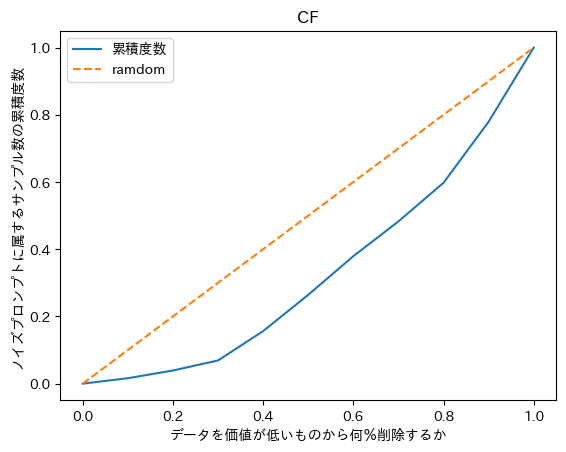

In [65]:
plt.plot(np.arange(0, 1.01, 0.1), CF, label='累積度数')
plt.plot(np.arange(0, 1.01, 0.1), np.arange(0, 1.01, 0.1), linestyle='--', label='ramdom')
plt.legend()
plt.title('CF')
plt.xlabel('データを価値が低いものから何％削除するか')
plt.ylabel('ノイズプロンプトに属するサンプル数の累積度数')
plt.savefig(output_path + 'CF.png')